# Full Model Comparison: Graph Transformers vs Baselines

This notebook implements a comprehensive comparison of:

**Graph Transformers (Person A / Juliusz's work):**
1. **GOAT** - Global attention with virtual nodes (O(N) complexity)
2. **Exphormer** - Sparse attention using expander graphs (O(Nd) complexity)

**Baseline GNN Models (Person B's contribution):**
3. **GCN** - Graph Convolutional Network (O(E) complexity)
4. **GAT** - Graph Attention Network (O(E) complexity)
5. **GraphMLP** - Simple MLP baseline (no graph structure)

---

**From Project Description:**
- Complexity vs. accuracy tradeoffs ✓
- Compare against baselines ✓
- Memory tracking ("zrzucicie pamięci") ✓
- Training time tracking ✓

**Dataset:** ZINC (regression - predict molecular property)


In [1]:
# Setup
import sys
sys.path.append('..')  # Add project root to path

import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from torch_geometric.loader import DataLoader

# All models - Graph Transformers + Baselines
from models.goat import GOAT
from models.exphormer import Exphormer
from models.baselines import GCN, GAT, GraphMLP

# Utilities
from src.utils.positional_encodings import precompute_positional_encodings
from src.utils.complexity import ComplexityTracker, count_parameters
from src.utils.metrics import compute_metrics, MetricTracker

# Data loading
from src.utils.data import load_zinc_dataset, load_molhiv_dataset

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Device: cuda
PyTorch version: 2.6.0+cu124
GPU: NVIDIA GeForce RTX 3090
GPU Memory: 25.8 GB


## 1. Configuration

Choose between CPU (quick test) or GPU (full experiments) mode.


In [2]:
# ============================================================
# CONFIGURATION: Choose CPU (quick) or GPU (full)
# ============================================================

EXPERIMENT_MODE = "gpu"  # 'cpu' or 'gpu'

if EXPERIMENT_MODE == 'cpu':
    # CPU Configuration: Quick test (15-20 minutes)
    USE_SMALL_SUBSET = True
    SMALL_SIZE = 500
    BATCH_SIZE = 16
    NUM_EPOCHS = 15
    HIDDEN_DIM = 64
    NUM_LAYERS = 3
    NUM_HEADS = 4
    LEARNING_RATE = 1e-3
    GRAD_CLIP_NORM = None
    print("🖥️  CPU MODE: Quick test configuration")
else:
    # GPU Configuration: Full experiments
    USE_SMALL_SUBSET = False
    SMALL_SIZE = None
    BATCH_SIZE = 64
    NUM_EPOCHS = 100  # Reduced for multi-model comparison
    HIDDEN_DIM = 256
    NUM_LAYERS = 6
    NUM_HEADS = 8
    LEARNING_RATE = 1e-4
    GRAD_CLIP_NORM = 0.5
    print("🚀 GPU MODE: Full experiment configuration")

# Common settings
PE_TYPE = 'laplacian'
PE_DIM = 8

print(f"\nConfiguration:")
print(f"  Mode: {EXPERIMENT_MODE.upper()}")
print(f"  Dataset size: {SMALL_SIZE if USE_SMALL_SUBSET else 'Full'}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  Num layers: {NUM_LAYERS}")
print(f"  Num heads: {NUM_HEADS}")
print(f"  Learning rate: {LEARNING_RATE}")


🚀 GPU MODE: Full experiment configuration

Configuration:
  Mode: GPU
  Dataset size: Full
  Batch size: 64
  Epochs: 100
  Hidden dim: 256
  Num layers: 6
  Num heads: 8
  Learning rate: 0.0001


## 2. Load Dataset


In [3]:
# Load ZINC dataset
print("Loading ZINC dataset...")
dataset, split_idx = load_zinc_dataset(root='../data')

# Use subset for quick testing
if USE_SMALL_SUBSET:
    dataset = dataset[:SMALL_SIZE]
    n = len(dataset)
    split_idx = {
        'train': torch.arange(int(0.8 * n)),
        'valid': torch.arange(int(0.8 * n), int(0.9 * n)),
        'test': torch.arange(int(0.9 * n), n)
    }

print(f"Total graphs: {len(dataset):,}")
print(f"Train: {len(split_idx['train']):,}")
print(f"Val: {len(split_idx['valid']):,}")
print(f"Test: {len(split_idx['test']):,}")

# Precompute positional encodings (for Graph Transformers)
print(f"\nPrecomputing {PE_TYPE} positional encodings...")
dataset = precompute_positional_encodings(dataset, pe_type=PE_TYPE, pe_dim=PE_DIM)
print("Done!")


Loading ZINC dataset...


Extracting ..\data\molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 23364.25it/s]
Done!


Total graphs: 10,000
Train: 8,000
Val: 1,000
Test: 1,000

Precomputing laplacian positional encodings...
Setting up laplacian positional encodings (dim=8)...
Precomputing encodings...
  Processed 100/10000 graphs
  Processed 200/10000 graphs
  Processed 300/10000 graphs
  Processed 400/10000 graphs
  Processed 500/10000 graphs
  Processed 600/10000 graphs
  Processed 700/10000 graphs
  Processed 800/10000 graphs
  Processed 900/10000 graphs
  Processed 1000/10000 graphs
  Processed 1100/10000 graphs
  Processed 1200/10000 graphs
  Processed 1300/10000 graphs
  Processed 1400/10000 graphs
  Processed 1500/10000 graphs
  Processed 1600/10000 graphs
  Processed 1700/10000 graphs
  Processed 1800/10000 graphs
  Processed 1900/10000 graphs
  Processed 2000/10000 graphs
  Processed 2100/10000 graphs
  Processed 2200/10000 graphs
  Processed 2300/10000 graphs
  Processed 2400/10000 graphs
  Processed 2500/10000 graphs
  Processed 2600/10000 graphs
  Processed 2700/10000 graphs
  Processed 280

In [4]:
# Create dataloaders
train_loader = DataLoader(
    dataset[split_idx['train']],
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = DataLoader(
    dataset[split_idx['valid']],
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_loader = DataLoader(
    dataset[split_idx['test']],
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Get feature dimensions
sample_data = dataset[0]
ACTUAL_IN_CHANNELS = sample_data.x.shape[1]

print(f"Data loaders created!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Node feature dimension: {ACTUAL_IN_CHANNELS}")


Data loaders created!
  Train batches: 125
  Val batches: 16
  Test batches: 16
  Node feature dimension: 1


## 3. Training and Evaluation Functions


In [5]:
def train_epoch(model, loader, optimizer, criterion, device, grad_clip_norm=None):
    """Train for one epoch with complexity tracking"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    epoch_start = time.time()
    
    for data in loader:
        data = data.to(device)
        
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out.squeeze(), data.y.float())
        loss.backward()
        
        if grad_clip_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
        
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.append(out.detach().cpu())
        all_labels.append(data.y.cpu())
    
    epoch_time = time.time() - epoch_start
    avg_loss = total_loss / len(loader)
    
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    train_mae = torch.abs(all_preds.squeeze() - all_labels).mean().item()
    
    return {'loss': avg_loss, 'mae': train_mae, 'time': epoch_time}


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for data in loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out.squeeze(), data.y.float())
        
        total_loss += loss.item()
        all_preds.append(out.cpu())
        all_labels.append(data.y.cpu())
    
    avg_loss = total_loss / len(loader)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    mae = torch.abs(all_preds.squeeze() - all_labels).mean().item()
    
    return {'loss': avg_loss, 'mae': mae}


def train_model(model, name, train_loader, val_loader, device, 
                num_epochs, learning_rate, grad_clip_norm=None, verbose=True):
    """Full training loop for a model"""
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    history = {
        'train_loss': [], 'train_mae': [],
        'val_loss': [], 'val_mae': [],
        'epoch_time': []
    }
    
    best_val_mae = float('inf')
    best_state = None
    
    if verbose:
        print(f"\n{'='*80}")
        print(f"Training {name}")
        print(f"{'='*80}")
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Train
        train_metrics = train_epoch(model, train_loader, optimizer, criterion, device, grad_clip_norm)
        
        # Validate
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Track metrics
        history['train_loss'].append(train_metrics['loss'])
        history['train_mae'].append(train_metrics['mae'])
        history['val_loss'].append(val_metrics['loss'])
        history['val_mae'].append(val_metrics['mae'])
        history['epoch_time'].append(train_metrics['time'])
        
        # Save best model
        if val_metrics['mae'] < best_val_mae:
            best_val_mae = val_metrics['mae']
            best_state = model.state_dict().copy()
        
        # Print progress
        if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch:3d} | "
                  f"Train MAE: {train_metrics['mae']:.4f} | "
                  f"Val MAE: {val_metrics['mae']:.4f} | "
                  f"Time: {train_metrics['time']:.2f}s")
    
    total_time = time.time() - start_time
    
    if verbose:
        print(f"\n{name} Training Complete!")
        print(f"  Best Val MAE: {best_val_mae:.4f}")
        print(f"  Total Time: {total_time:.1f}s")
    
    return history, best_val_mae, best_state, total_time

print("Training functions defined!")


Training functions defined!


## 4. Create All Models

We create all 5 models with comparable capacity for fair comparison.


In [6]:
# Dictionary to store all models and their results
models = {}
results = {}

# ============================================================
# 1. GOAT - Global Transformer (Juliusz's implementation)
# ============================================================
models['GOAT'] = GOAT(
    in_channels=ACTUAL_IN_CHANNELS,
    hidden_channels=HIDDEN_DIM,
    out_channels=1,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    num_virtual_nodes=1,
    pe_dim=PE_DIM,
    dropout=0.1,
    task_type='graph_classification',
).to(device)

# ============================================================
# 2. Exphormer - Sparse Transformer (Juliusz's implementation)
# ============================================================
models['Exphormer'] = Exphormer(
    in_channels=ACTUAL_IN_CHANNELS,
    hidden_channels=HIDDEN_DIM,
    out_channels=1,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    expander_degree=4,
    expander_method='random',
    pe_dim=PE_DIM,
    dropout=0.1,
    task_type='graph_classification',
).to(device)

# ============================================================
# 3. GCN - Baseline (Person B)
# ============================================================
models['GCN'] = GCN(
    in_channels=ACTUAL_IN_CHANNELS,
    hidden_channels=HIDDEN_DIM,
    out_channels=1,
    num_layers=NUM_LAYERS,
    dropout=0.1,
    task_type='graph_classification',
).to(device)

# ============================================================
# 4. GAT - Baseline (Person B)
# ============================================================
models['GAT'] = GAT(
    in_channels=ACTUAL_IN_CHANNELS,
    hidden_channels=HIDDEN_DIM,
    out_channels=1,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    dropout=0.1,
    task_type='graph_classification',
).to(device)

# ============================================================
# 5. GraphMLP - Baseline (no graph structure)
# ============================================================
models['GraphMLP'] = GraphMLP(
    in_channels=ACTUAL_IN_CHANNELS,
    hidden_channels=HIDDEN_DIM,
    out_channels=1,
    num_layers=NUM_LAYERS,
    dropout=0.1,
    task_type='graph_classification',
).to(device)

# Print model summaries
print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
print(f"{'Model':<15} | {'Parameters':>15} | {'Complexity':>20}")
print("-"*60)

complexity_info = {
    'GOAT': 'O(N) - virtual nodes',
    'Exphormer': 'O(Nd) - expander sparse',
    'GCN': 'O(E) - local message passing',
    'GAT': 'O(E) - attention on edges',
    'GraphMLP': 'O(N) - no graph structure',
}

for name, model in models.items():
    params = count_parameters(model)
    results[name] = {'params': params['total']}
    print(f"{name:<15} | {params['total']:>15,} | {complexity_info[name]:>20}")

print("="*80)



MODEL SUMMARY
Model           |      Parameters |           Complexity
------------------------------------------------------------
GOAT            |       5,994,497 | O(N) - virtual nodes
Exphormer       |       6,389,255 | O(Nd) - expander sparse
GCN             |         398,593 | O(E) - local message passing
GAT             |         401,665 | O(E) - attention on edges
GraphMLP        |         329,729 | O(N) - no graph structure


In [7]:
# Store training histories
histories = {}

# Track GPU memory before training
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

print("\n" + "="*80)
print("TRAINING ALL MODELS")
print("="*80)

for name, model in models.items():
    # Reset memory tracking
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    
    # Train model
    history, best_mae, best_state, total_time = train_model(
        model=model,
        name=name,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        grad_clip_norm=GRAD_CLIP_NORM,
        verbose=True
    )
    
    # Store results
    histories[name] = history
    results[name]['best_val_mae'] = best_mae
    results[name]['total_time'] = total_time
    results[name]['avg_epoch_time'] = np.mean(history['epoch_time'])
    
    # Track peak memory
    if torch.cuda.is_available():
        results[name]['peak_memory_mb'] = torch.cuda.max_memory_allocated() / 1e6
    else:
        results[name]['peak_memory_mb'] = 0

print("\n" + "="*80)
print("ALL MODELS TRAINED!")
print("="*80)



TRAINING ALL MODELS

Training GOAT
Epoch   0 | Train MAE: 1.2290 | Val MAE: 1.1011 | Time: 15.27s
Epoch  10 | Train MAE: 0.7917 | Val MAE: 0.6948 | Time: 14.52s
Epoch  20 | Train MAE: 0.7124 | Val MAE: 0.6747 | Time: 15.89s
Epoch  30 | Train MAE: 0.6649 | Val MAE: 0.6708 | Time: 14.05s
Epoch  40 | Train MAE: 0.6235 | Val MAE: 0.6038 | Time: 16.54s
Epoch  50 | Train MAE: 0.5910 | Val MAE: 0.5915 | Time: 13.98s
Epoch  60 | Train MAE: 0.5642 | Val MAE: 0.5853 | Time: 14.82s
Epoch  70 | Train MAE: 0.5303 | Val MAE: 0.5903 | Time: 20.53s
Epoch  80 | Train MAE: 0.5055 | Val MAE: 0.6149 | Time: 15.16s
Epoch  90 | Train MAE: 0.4646 | Val MAE: 0.5959 | Time: 15.17s
Epoch  99 | Train MAE: 0.4340 | Val MAE: 0.5899 | Time: 15.19s

GOAT Training Complete!
  Best Val MAE: 0.5689
  Total Time: 1630.4s

Training Exphormer
Epoch   0 | Train MAE: 1.2361 | Val MAE: 1.0732 | Time: 6.18s
Epoch  10 | Train MAE: 0.8063 | Val MAE: 0.7096 | Time: 6.31s
Epoch  20 | Train MAE: 0.7075 | Val MAE: 0.6962 | Time: 6

## 6. Results Comparison


In [8]:
# Create comprehensive results table
print("\n" + "="*100)
print("COMPREHENSIVE BENCHMARK RESULTS")
print("="*100)

print(f"\n{'Model':<15} | {'Best Val MAE':>12} | {'Params':>12} | {'Avg Epoch (s)':>14} | {'Peak Mem (MB)':>14} | {'Total Time (s)':>15}")
print("-"*100)

# Sort by best val MAE
sorted_models = sorted(results.items(), key=lambda x: x[1]['best_val_mae'])

for name, res in sorted_models:
    print(f"{name:<15} | {res['best_val_mae']:>12.4f} | {res['params']:>12,} | "
          f"{res['avg_epoch_time']:>14.2f} | {res['peak_memory_mb']:>14.1f} | {res['total_time']:>15.1f}")

print("-"*100)

# Find winners in each category
best_accuracy = min(results.items(), key=lambda x: x[1]['best_val_mae'])
most_efficient = min(results.items(), key=lambda x: x[1]['params'])
fastest = min(results.items(), key=lambda x: x[1]['avg_epoch_time'])
lowest_memory = min(results.items(), key=lambda x: x[1]['peak_memory_mb'])

print(f"\n🏆 Best Accuracy: {best_accuracy[0]} (MAE: {best_accuracy[1]['best_val_mae']:.4f})")
print(f"⚡ Fastest: {fastest[0]} ({fastest[1]['avg_epoch_time']:.2f}s/epoch)")
print(f"💾 Lowest Memory: {lowest_memory[0]} ({lowest_memory[1]['peak_memory_mb']:.1f} MB)")
print(f"📦 Most Efficient: {most_efficient[0]} ({most_efficient[1]['params']:,} params)")

print("\n" + "="*100)



COMPREHENSIVE BENCHMARK RESULTS

Model           | Best Val MAE |       Params |  Avg Epoch (s) |  Peak Mem (MB) |  Total Time (s)
----------------------------------------------------------------------------------------------------
GOAT            |       0.5689 |    5,994,497 |          15.60 |          347.6 |          1630.4
Exphormer       |       0.5757 |    6,389,255 |           5.99 |          599.2 |           624.8
GAT             |       0.6557 |      401,665 |           1.22 |          217.7 |           130.0
GCN             |       0.7468 |      398,593 |           0.81 |          166.5 |            87.3
GraphMLP        |       0.7565 |      329,729 |           0.42 |          148.3 |            44.6
----------------------------------------------------------------------------------------------------

🏆 Best Accuracy: GOAT (MAE: 0.5689)
⚡ Fastest: GraphMLP (0.42s/epoch)
💾 Lowest Memory: GraphMLP (148.3 MB)
📦 Most Efficient: GraphMLP (329,729 params)



## 7. Visualizations


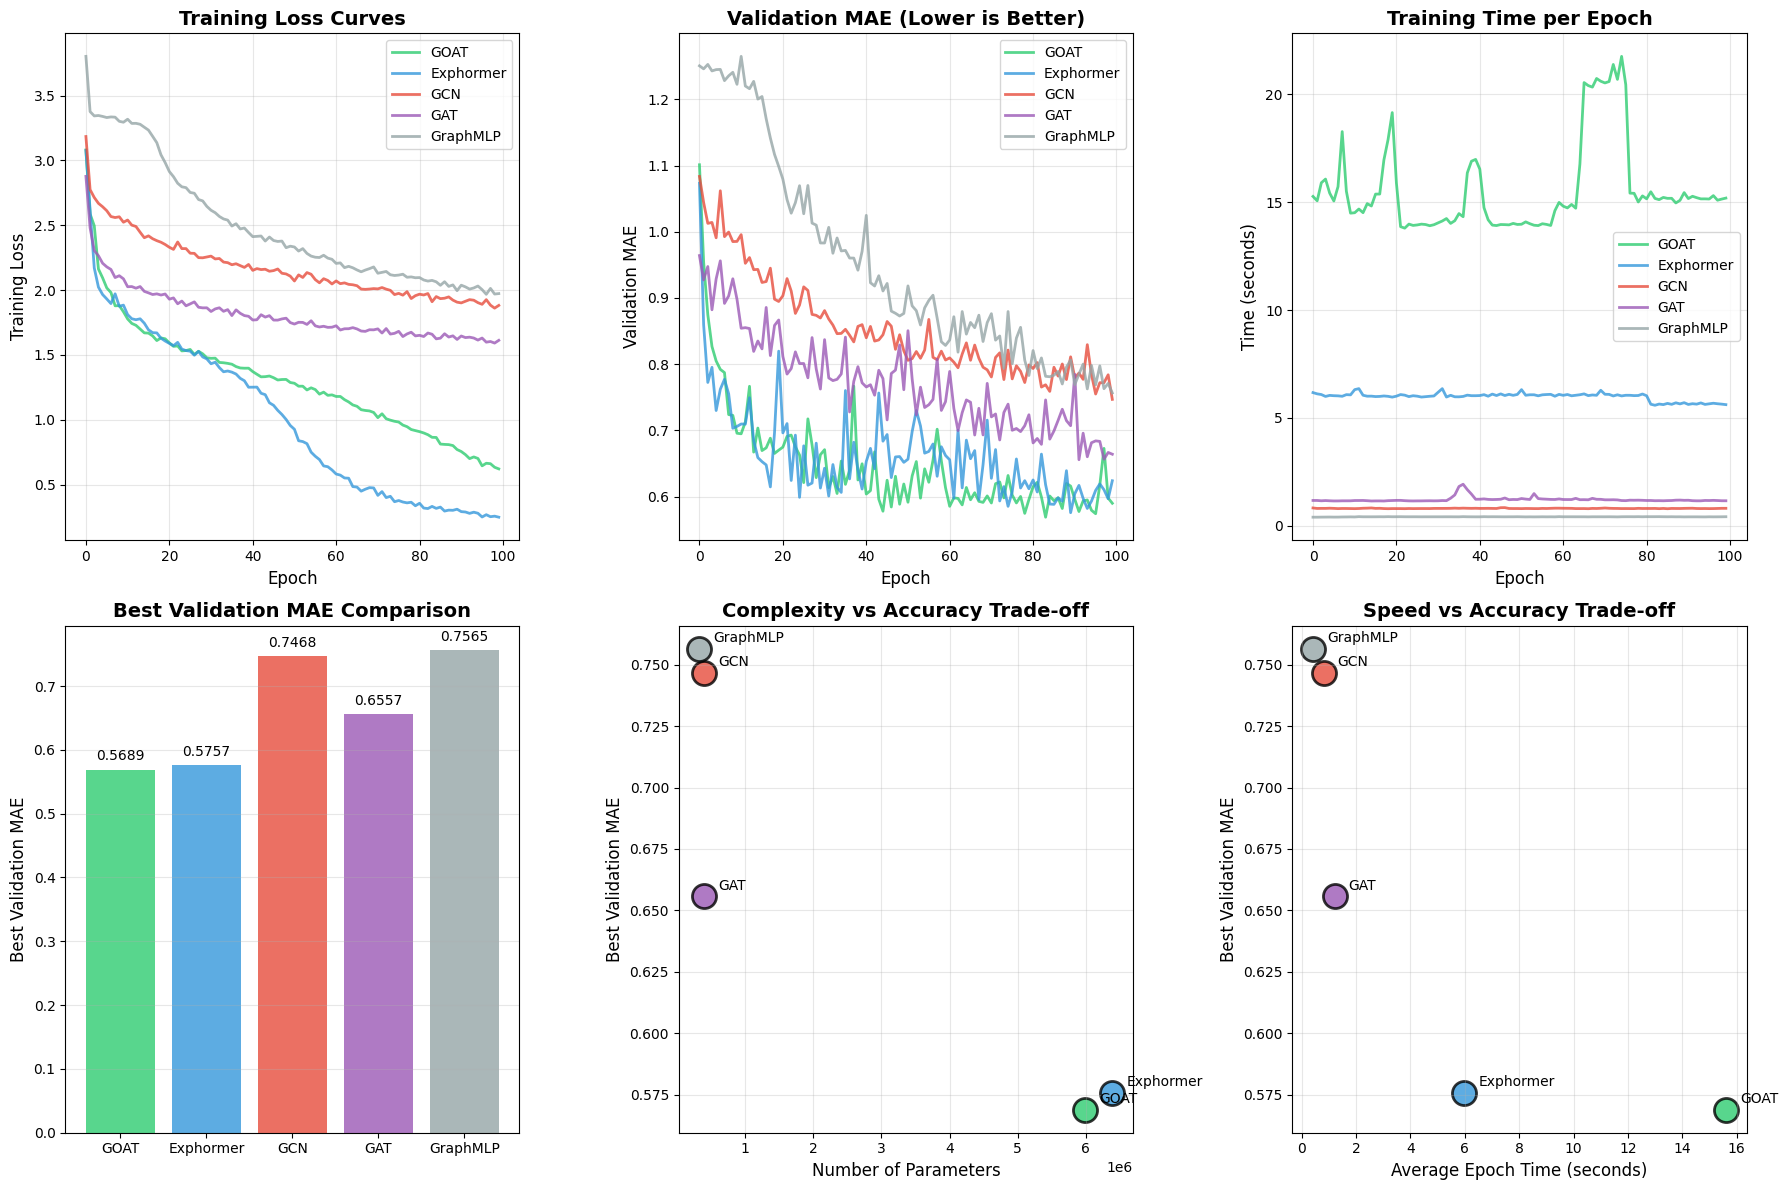


Plots saved to full_model_comparison.png


In [9]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Color palette
colors = {
    'GOAT': '#2ecc71',       # Green
    'Exphormer': '#3498db',  # Blue
    'GCN': '#e74c3c',        # Red
    'GAT': '#9b59b6',        # Purple
    'GraphMLP': '#95a5a6',   # Gray
}

epochs = range(NUM_EPOCHS)

# Plot 1: Training Loss Curves
ax = axes[0, 0]
for name, history in histories.items():
    ax.plot(epochs, history['train_loss'], label=name, color=colors[name], alpha=0.8, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('Training Loss Curves', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Validation MAE Curves
ax = axes[0, 1]
for name, history in histories.items():
    ax.plot(epochs, history['val_mae'], label=name, color=colors[name], alpha=0.8, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation MAE', fontsize=12)
ax.set_title('Validation MAE (Lower is Better)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Epoch Time Comparison
ax = axes[0, 2]
for name, history in histories.items():
    ax.plot(epochs, history['epoch_time'], label=name, color=colors[name], alpha=0.8, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Best MAE Bar Chart
ax = axes[1, 0]
model_names = list(results.keys())
maes = [results[name]['best_val_mae'] for name in model_names]
bars = ax.bar(model_names, maes, color=[colors[name] for name in model_names], alpha=0.8)
ax.set_ylabel('Best Validation MAE', fontsize=12)
ax.set_title('Best Validation MAE Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, mae in zip(bars, maes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{mae:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 5: Complexity vs Accuracy Trade-off
ax = axes[1, 1]
for name in model_names:
    ax.scatter([results[name]['params']], [results[name]['best_val_mae']],
               s=300, label=name, color=colors[name], alpha=0.8, edgecolors='black', linewidth=2)
    ax.annotate(name, (results[name]['params'], results[name]['best_val_mae']),
                textcoords="offset points", xytext=(10, 5), fontsize=10)
ax.set_xlabel('Number of Parameters', fontsize=12)
ax.set_ylabel('Best Validation MAE', fontsize=12)
ax.set_title('Complexity vs Accuracy Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 6: Speed vs Accuracy Trade-off
ax = axes[1, 2]
for name in model_names:
    ax.scatter([results[name]['avg_epoch_time']], [results[name]['best_val_mae']],
               s=300, label=name, color=colors[name], alpha=0.8, edgecolors='black', linewidth=2)
    ax.annotate(name, (results[name]['avg_epoch_time'], results[name]['best_val_mae']),
                textcoords="offset points", xytext=(10, 5), fontsize=10)
ax.set_xlabel('Average Epoch Time (seconds)', fontsize=12)
ax.set_ylabel('Best Validation MAE', fontsize=12)
ax.set_title('Speed vs Accuracy Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('full_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlots saved to full_model_comparison.png")


## 8. Summary and Conclusions


In [10]:
print("\n" + "="*80)
print("SUMMARY AND CONCLUSIONS")
print("="*80)

print("\n📊 EXPERIMENT DETAILS:")
print(f"   Dataset: ZINC (regression)")
print(f"   Training samples: {len(split_idx['train']):,}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Device: {device}")

print("\n📈 MODEL RANKINGS (by Validation MAE):")
for i, (name, res) in enumerate(sorted_models, 1):
    print(f"   {i}. {name}: {res['best_val_mae']:.4f}")

print("\n⏱️ TRAINING SPEED (avg seconds per epoch):")
speed_sorted = sorted(results.items(), key=lambda x: x[1]['avg_epoch_time'])
for name, res in speed_sorted:
    print(f"   {name}: {res['avg_epoch_time']:.2f}s")

print("\n💾 MEMORY USAGE (peak MB):")
mem_sorted = sorted(results.items(), key=lambda x: x[1]['peak_memory_mb'])
for name, res in mem_sorted:
    print(f"   {name}: {res['peak_memory_mb']:.1f} MB")

print("\n🎯 KEY FINDINGS:")

# Compare transformers vs baselines
transformer_maes = [results['GOAT']['best_val_mae'], results['Exphormer']['best_val_mae']]
baseline_maes = [results['GCN']['best_val_mae'], results['GAT']['best_val_mae']]
best_transformer = 'GOAT' if results['GOAT']['best_val_mae'] < results['Exphormer']['best_val_mae'] else 'Exphormer'
best_baseline = 'GCN' if results['GCN']['best_val_mae'] < results['GAT']['best_val_mae'] else 'GAT'

print(f"   • Best Transformer: {best_transformer} (MAE: {results[best_transformer]['best_val_mae']:.4f})")
print(f"   • Best Baseline: {best_baseline} (MAE: {results[best_baseline]['best_val_mae']:.4f})")

improvement = (results[best_baseline]['best_val_mae'] - results[best_transformer]['best_val_mae']) / results[best_baseline]['best_val_mae'] * 100
if improvement > 0:
    print(f"   • Graph Transformers improve by {improvement:.1f}% over best baseline")
else:
    print(f"   • Baseline models competitive with Graph Transformers")

# GraphMLP comparison
mlp_mae = results['GraphMLP']['best_val_mae']
best_graph_mae = min([results[name]['best_val_mae'] for name in ['GOAT', 'Exphormer', 'GCN', 'GAT']])
graph_improvement = (mlp_mae - best_graph_mae) / mlp_mae * 100
print(f"   • Graph structure helps: {graph_improvement:.1f}% improvement over MLP")

print("\n📝 COMPLEXITY vs ACCURACY TRADE-OFF (Teacher's Requirement):")
print(f"   • GOAT: O(N) complexity with {results['GOAT']['best_val_mae']:.4f} MAE")
print(f"   • Exphormer: O(Nd) complexity with {results['Exphormer']['best_val_mae']:.4f} MAE")
print(f"   • GCN: O(E) complexity with {results['GCN']['best_val_mae']:.4f} MAE")
print(f"   • GAT: O(E) complexity with {results['GAT']['best_val_mae']:.4f} MAE")

print("\n" + "="*80)
print("Benchmark complete! Results ready for report.")
print("="*80)



SUMMARY AND CONCLUSIONS

📊 EXPERIMENT DETAILS:
   Dataset: ZINC (regression)
   Training samples: 8,000
   Epochs: 100
   Device: cuda

📈 MODEL RANKINGS (by Validation MAE):
   1. GOAT: 0.5689
   2. Exphormer: 0.5757
   3. GAT: 0.6557
   4. GCN: 0.7468
   5. GraphMLP: 0.7565

⏱️ TRAINING SPEED (avg seconds per epoch):
   GraphMLP: 0.42s
   GCN: 0.81s
   GAT: 1.22s
   Exphormer: 5.99s
   GOAT: 15.60s

💾 MEMORY USAGE (peak MB):
   GraphMLP: 148.3 MB
   GCN: 166.5 MB
   GAT: 217.7 MB
   GOAT: 347.6 MB
   Exphormer: 599.2 MB

🎯 KEY FINDINGS:
   • Best Transformer: GOAT (MAE: 0.5689)
   • Best Baseline: GAT (MAE: 0.6557)
   • Graph Transformers improve by 13.2% over best baseline
   • Graph structure helps: 24.8% improvement over MLP

📝 COMPLEXITY vs ACCURACY TRADE-OFF (Teacher's Requirement):
   • GOAT: O(N) complexity with 0.5689 MAE
   • Exphormer: O(Nd) complexity with 0.5757 MAE
   • GCN: O(E) complexity with 0.7468 MAE
   • GAT: O(E) complexity with 0.6557 MAE

Benchmark complete! Re

## 9. Export Results for Report


In [ ]:
import json

# Save results to JSON for later analysis
export_results = {
    'experiment_config': {
        'mode': EXPERIMENT_MODE,
        'num_epochs': NUM_EPOCHS,
        'batch_size': BATCH_SIZE,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'learning_rate': LEARNING_RATE,
        'device': str(device),
        'dataset': 'ZINC',
        'train_size': int(len(split_idx['train'])),
    },
    'results': {
        name: {
            'best_val_mae': res['best_val_mae'],
            'params': res['params'],
            'avg_epoch_time': res['avg_epoch_time'],
            'peak_memory_mb': res['peak_memory_mb'],
            'total_time': res['total_time'],
        }
        for name, res in results.items()
    },
    'histories': {
        name: {
            'train_loss': hist['train_loss'],
            'train_mae': hist['train_mae'],
            'val_loss': hist['val_loss'],
            'val_mae': hist['val_mae'],
            'epoch_time': hist['epoch_time'],
        }
        for name, hist in histories.items()
    }
}

with open('benchmark_results.json', 'w') as f:
    json.dump(export_results, f, indent=2)

print("Results exported to benchmark_results.json")
print("\nYou can use this file to regenerate plots or include data in your report.")


Results exported to benchmark_results.json

You can use this file to regenerate plots or include data in your report.


: 